# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023 

---

## Zestaw zadań 8: Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL (część 2)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów

In [3]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań

In [4]:
# Przydatne funkcje

def geopandas2pysal(polygon):
    x,y = polygon.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    polygon = ps.cg.Polygon(coords)
    return polygon

#### UWAGA!
Znaczna część przykładów i dokumentacji modułów wchodzących w skład pakietu pysal dostępna w internecie nie dotyczny ich najnowszych wersji.
Z tego powodu wygodniejszym sposobem zdobywania informacji na temat wykorzystywanych modułów, klas i funkcji jest wykorzystanie funkcji help(), np.: help(ps), help(pp), help(pp.pointpattern).

### Zadanie 1: Import i przygotowanie danych (5 pkt)
Wykorzystując funkcję `geopandas.read_file()` zaimportuj do notatnika dane z dołączonego do niego pliku (zakres importowanych danych i odwzorowanie kartograficzne nie wymagają zmian). Następnie, wykorzystując funkcję `geopandas.GeoDataFrame.dissolve()` przygotuj tablicę zawierającą geometrię granic całego kraju. Dostosuj informację znajdującą się w kolumnie "Nazwa" stworzonej tablicy do informacji w niej zawartej.

In [5]:
powiaty = gpd.read_file("Powiaty.zip")
kraj = powiaty.dissolve()
kraj["Nazwa"] = "Polska"

In [6]:
powiaty

,Nazwa,geometry
0,powiat ropczycko-sędziszowski,"POLYGON ((692305.365 260282.248, 692313.646 26..."
1,powiat łosicki,"POLYGON ((753920.175 497017.076, 753918.822 49..."
2,powiat piaseczyński,"POLYGON ((644442.384 473992.041, 644345.678 47..."
3,powiat radomski,"POLYGON ((638056.482 404421.246, 638059.412 40..."
4,powiat sierpecki,"POLYGON ((534236.749 555932.727, 534235.027 55..."
...,...,...
375,powiat nowodworski,"POLYGON ((521445.985 722541.335, 521523.278 72..."
376,powiat jaworski,"POLYGON ((303544.254 353195.337, 303547.016 35..."
377,powiat węgrowski,"POLYGON ((702854.223 532567.782, 702853.911 53..."
378,powiat wejherowski,"POLYGON ((430377.866 773965.783, 430351.853 77..."


In [7]:
kraj

,geometry,Nazwa
0,"POLYGON ((314574.250 311049.909, 314544.080 31...",Polska


### Zadanie 2: Jednorodny proces punktowy Poissona (15 pkt)

Przygotuj funkcję `homogeneous_poisson_on_polygon()`, która będzie generować jednorodny proces punktowy Poissona w obrębie określonego obszaru.
Następnie wykorzystaj przygotowaną funkcję do wygenerowania przykładowego rozkładu punktów i przedstaw go w postaci wykresu punktowego nałożonego na kontur granic kraju.

Parametry rozkładu do wygenerowania:
 - intensywność procesu: $3 \cdot 10^{-9} pkt/m^2$ 
 - obszar: Polska
 - crs: idenyczny jak crs wczytanych danych
 
Przydatne klasy, funkcje i własności:
- `pointpats.as_window()`
- `pointpats.Window()`
- `pointpats.process.PoissonPointProcess()`
- `geopandas.GeoSeries.area`
- `geopandas.GeoSeries.from_xy()`
- `geopandas.GeoSeries.crs`
- `geopandas.GeoSeries.set_crs()`
- `geopandas.GeoDataFrame.crs`
- `geopandas.GeoDataFrame.set_crs()`
- `geopandas2pysal()` - dostępna na początku notatnika

#### a) Przygotowanie funkcji

In [8]:
def homogeneous_poisson_on_polygon(intensity, polygon, crs):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    window = pp.as_window(geopandas2pysal(polygon))
    points = pp.process.PoissonPointProcess(window, int(polygon.area*intensity), 1, conditioning=True)
    pointsProcessed = points.realizations[0].transpose()
    pointsG = gpd.GeoSeries.from_xy(pointsProcessed[0], pointsProcessed[1])
    pointsG.set_crs(crs)
    return pointsG

#### b) Wygenerowanie danych

In [9]:
homogeneous = homogeneous_poisson_on_polygon(3e-9, kraj["geometry"][0], kraj.crs)

#### c) Wizualizacja

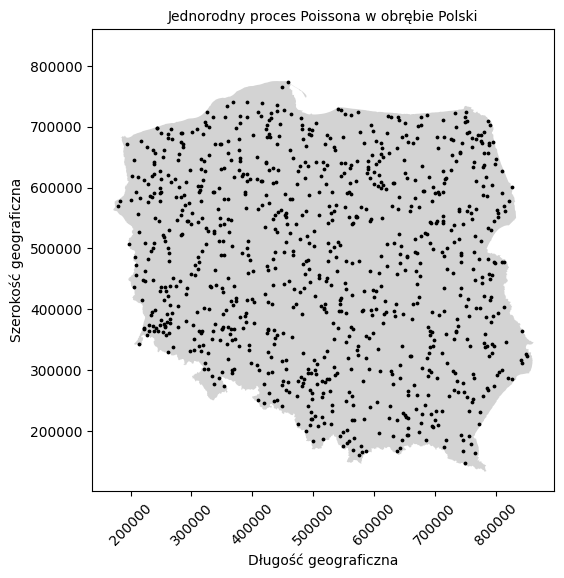

In [10]:
fig, axes = plt.subplots(1, 1, figsize = (6,6))

kraj.plot(ax = axes, color = "lightgray")
homogeneous.plot(ax = axes, markersize = 3, color = "black")
axes.set_title("Jednorodny proces Poissona w obrębie Polski", fontsize = 10)
axes.set_xlabel("Długość geograficzna");      
axes.set_ylabel("Szerokość geograficzna");
axes.tick_params(axis = 'x', labelrotation = 45)
axes.axis('square');

### Zadanie 3: Sklasteryzowany proces punktowy Poissona (15 pkt)

Przygotuj funkcję `clustered_poisson_on_polygon()`, która będzie generować sklasteryzowany proces punktowy Poissona (proces Neymana-Scotta) w obrębie określonego obszaru.
Następnie wykorzystaj przygotowaną funkcję do wygenerowania przykładowego rozkładu punktów i przedstaw go w postaci wykresu punktowego nałożonego na kontur granic kraju.

Parametry rozkładu do wygenerowania:
 - intensywność procesu macierzystego: $0.5 \cdot 10^{-10} pkt/m^2$ 
 - liczba punktów: $1000$
 - promień klastra: $50 km$
 - obszar: Polska
 - crs: idenyczny jak crs wczytanych danych

Przydatne klasy, funkcje i własności:
- `pointpats.as_window()`
- `pointpats.Window()`
- `pointpats.process.PoissonClusterPointProcess()`
- `geopandas.GeoSeries.area`
- `geopandas.GeoSeries.from_xy()`
- `geopandas.GeoSeries.crs`
- `geopandas.GeoSeries.set_crs()`
- `geopandas.GeoDataFrame.crs`
- `geopandas.GeoDataFrame.set_crs()`
- `geopandas2pysal()` - dostępna na początku notatnika

#### a) Przygotowanie funkcji

In [11]:
def clustered_poisson_on_polygon(parent_intensity, number_of_points, cluster_radius, polygon, crs):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    number_of_points: int
        Liczba dodatnia określająca ilość generowanych punktów.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    window = pp.as_window(geopandas2pysal(polygon))
    points = pp.process.PoissonClusterPointProcess(window, number_of_points, int(polygon.area*parent_intensity), cluster_radius, 1, conditioning=True)
    pointsProcessed = points.realizations[0].transpose()
    pointsG = gpd.GeoSeries.from_xy(pointsProcessed[0], pointsProcessed[1])
    pointsG.set_crs(crs)
    return pointsG

#### b) Wygenerowanie danych

In [12]:
clustered = clustered_poisson_on_polygon(5e-11, 1000, 50000, kraj["geometry"][0], kraj.crs)

#### c) Wizualizacja

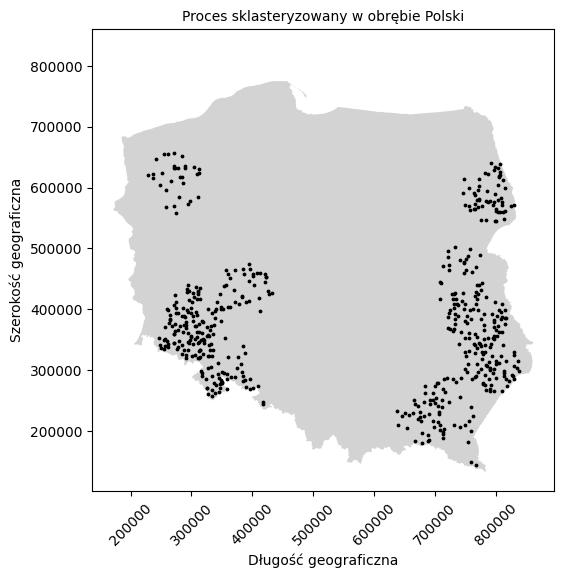

In [13]:
fig, axes = plt.subplots(1, 1, figsize = (6,6))

kraj.plot(ax = axes, color = "lightgray")
clustered.plot(ax = axes, markersize = 3, color = "black")
axes.set_title("Proces sklasteryzowany w obrębie Polski", fontsize = 10)
axes.set_xlabel("Długość geograficzna");      
axes.set_ylabel("Szerokość geograficzna");
axes.tick_params(axis = 'x', labelrotation = 45)
axes.axis('square');

### Zadanie 4: Badanie intensywności procesów punktowych metodą szacowania lokalnego  (15 pkt)

Przygotuj funkcję `point_count_on_subregions()`, która będzie zliczać punkty w obrębie podobszarów oraz funkcję `intensity_on_subregions()`, która będzie obliczać intensywność procesu punktowego w obrębie podobszarów.

Następnie wykorzystaj przygotowane funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów na obszarze poszczegolnych powiatów.

Przedstaw wyniki analizy graficznie w postaci kartogramów z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

Przydatne klasy, funkcje i własności:
- `geopandas.GeoSeries.within()`
- `geopandas.GeoSeries.area`

#### a) Przygotowanie funkcji

In [14]:
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """
    counts = [np.sum(points.within(subregion)) for subregion in subregions['geometry']]
    return pd.Series(counts)
    
def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
    return point_count_on_subregions(points, subregions)/subregions.area

#### b) Wygenerowanie danych

In [15]:
powiaty['homogeneous_intensity'] = intensity_on_subregions(homogeneous, powiaty)
powiaty['cluster_intensity'] = intensity_on_subregions(clustered, powiaty)

#### c) Wizualizacja

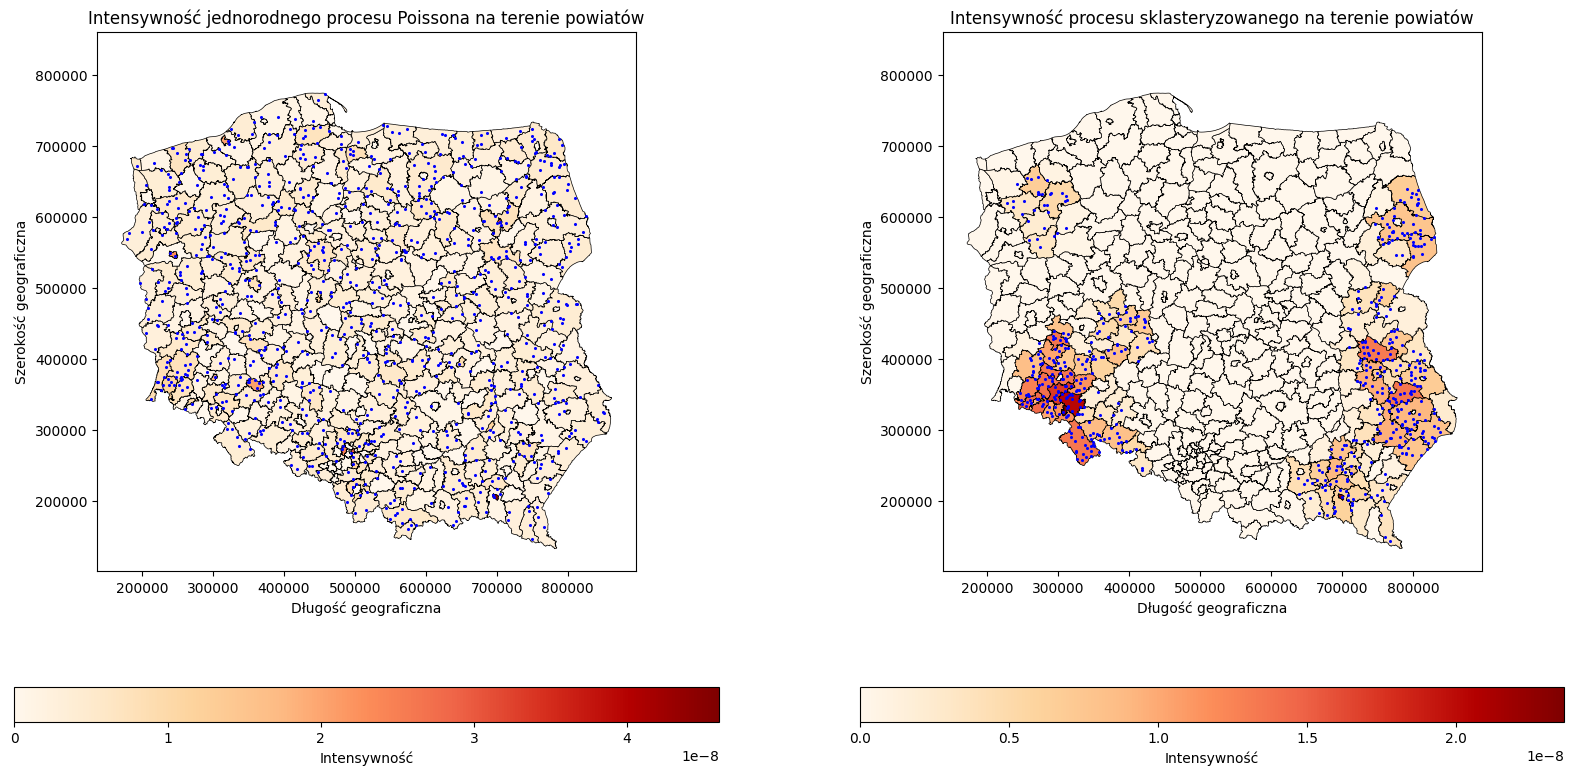

In [16]:
fig, axes = plt.subplots(1, 2, figsize = [20,10])

powiaty.plot(column = 'homogeneous_intensity', linewidth=0.5, ax = axes[0], cmap='OrRd', legend=True, 
              legend_kwds={'label': "Intensywność", 'orientation': "horizontal"}, edgecolor="black")
homogeneous.plot(ax = axes[0], color = "blue", markersize = 1.5)
axes[0].set_title("Intensywność jednorodnego procesu Poissona na terenie powiatów");
axes[0].set_xlabel("Długość geograficzna")   
axes[0].set_ylabel("Szerokość geograficzna")
axes[0].axis('square')

powiaty.plot(column = 'cluster_intensity', linewidth=0.5, ax = axes[1], cmap='OrRd', legend=True, 
              legend_kwds={'label': "Intensywność", 'orientation': "horizontal"}, edgecolor="black");
clustered.plot(ax = axes[1], color = "blue", markersize = 1.5)
axes[1].set_title("Intensywność procesu sklasteryzowanego na terenie powiatów")
axes[1].set_xlabel("Długość geograficzna")   
axes[1].set_ylabel("Szerokość geograficzna")
axes[1].axis('square');